In [27]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# About

__Author:__ Pat McCornack

__Date:__ December 2024

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
Around 15% of the data is missing for every variable, these were dropped. A handful of observations have a value of -9999 for at least one variable, these were dropped. 87 observations had leaf wetness values over 100%, with a max of 101.4%. These were manually adjusted to 100. 

__Outputs:__  
Cleaned data is output to `./data/02-clean/sci-christy-airstrip-clean-2021-2023.csv`. 

In [28]:
def subset_summer(df):
    """
    Subset data to summer months (May-Sept). This is done because summer is the ecologically relevant period for fog. 

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to subset.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe subset to May 01 - September 30. 
    """
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [29]:
# Specify parameters
summer_subset = False  # Subset to the summer months?

In [30]:
#### Specify Arguments ###
# Source data paths
src_dir = './data/01-raw/met-station/'
src_fname = 'sci-christy-airstrip-2021-2023.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = './data/02-clean/'
out_fname = 'sci-christy-airstrip-clean-2021-2023.csv'
out_fpath = os.path.join(outdir, out_fname)

# Define variable name map
var_dict = {
    'time (PST)' : 'time',
    'air temperature (C)' :'air-temperature-degc',
    'relative humidity (%)' :'relative-humidity-pct',
    'wind speed (m/s)' : 'wind-speed-ms',
    'wind gust (m/s)' : 'wind-speed-max-ms',
    'wind direction (deg)' : 'wind-direction-deg',
    'rain (mm)' : 'rainfall-mm',
    'solar radiation (wm2)' :'solar-radiation-wm-2',
    'atm pressure (kpa)' : 'barometric-pressure-kpa',
    'leaf wetness (%)' : 'leaf-wetness-pct'
}

In [31]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Suset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())
df['time (PST)'] = pd.to_datetime(df['time (PST)'])
    
# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

### Missing Values
Observations:
1. There's a bunch of missing observations, but they're uniformly missing across most variables. Leaf wetness is missing fewer.
2. The missing observations aren't restricted to a specific window of time.

Actions: 
1. Drop all missing. 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100185 entries, 0 to 100184
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   time (PST)             100185 non-null  datetime64[ns]
 1   air temperature (C)    85675 non-null   float64       
 2   relative humidity (%)  85675 non-null   float64       
 3   wind speed (m/s)       85675 non-null   float64       
 4   wind gust (m/s)        85675 non-null   float64       
 5   wind direction (deg)   85675 non-null   float64       
 6   rain (mm)              85675 non-null   float64       
 7   solar radiation (wm2)  85675 non-null   float64       
 8   atm pressure (kpa)     85675 non-null   float64       
 9   leaf wetness (%)       89903 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 7.6 MB


In [33]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                            24792
mean     2021-12-04 08:32:23.308325376
min                2021-03-08 13:15:00
25%                2021-06-23 09:37:30
50%                2021-11-09 18:47:30
75%                2022-03-17 17:47:30
max                2023-11-06 03:25:00
Name: time (PST), dtype: object

In [34]:
# Drop missing observations
df = df.dropna()

### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. About half of the variables have observations with values of around -9999. This likely codes bad values. 
2. There are very few of these values. Ok to drop them all. 
3. There's some leaf wetness values over 100.  


Actions
1. Check the bad data at -9999.
2. Drop these values. 


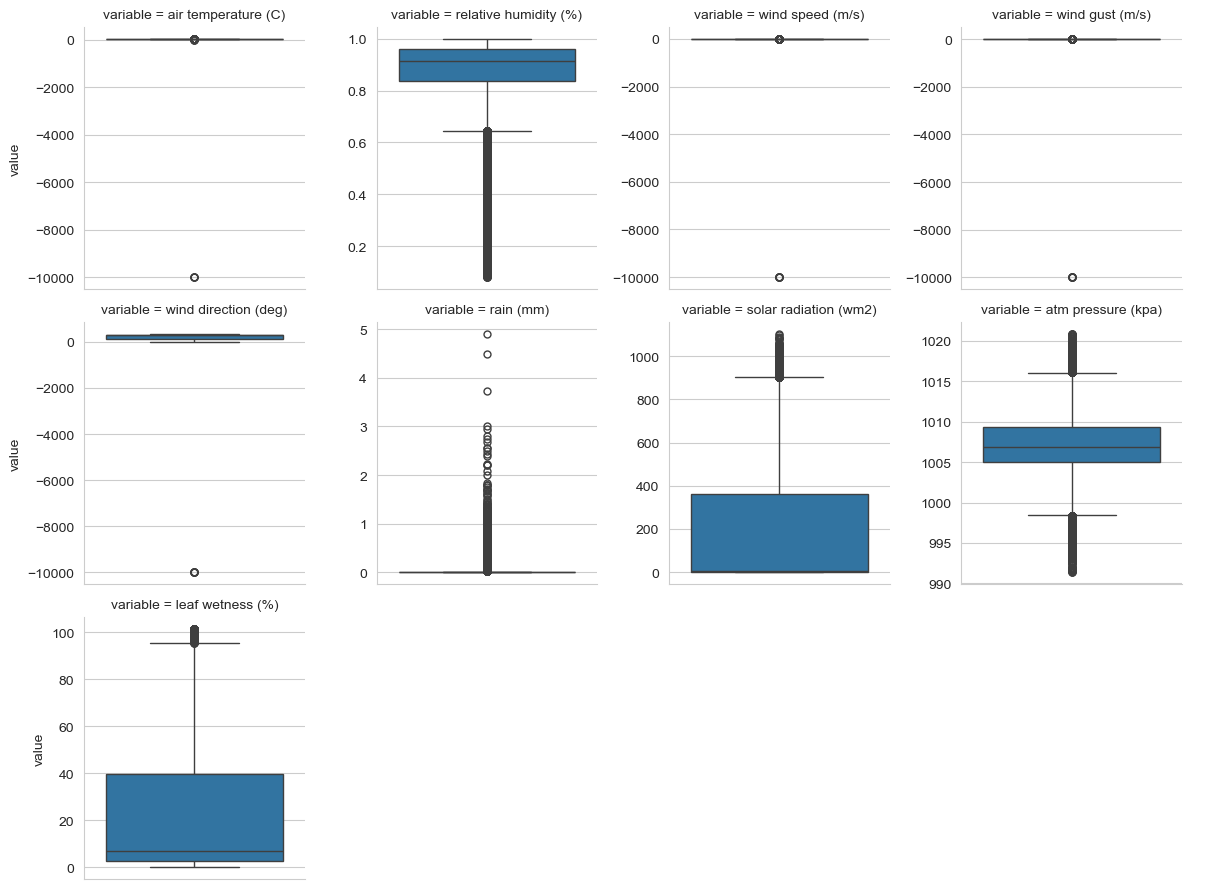

In [35]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [36]:
#### Chekc the actual values ####
df.describe()

,time (PST),air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (wm2),atm pressure (kpa),leaf wetness (%)
count,75393,75393.000000,75393.000000,75393.000000,75393.000000,75393.000000,75393.000000,75393.000000,75393.000000,75393.000000
mean,2022-08-13 05:51:48.873502976,13.465822,0.870363,1.061132,3.255453,243.769534,0.005308,199.038770,1007.337039,25.267565
min,2021-03-08 13:25:00,-9999.000000,0.081000,-9999.000000,-9999.000000,-9999.000000,0.000000,0.000000,991.400000,0.000000
25%,2021-10-11 00:10:00,11.500000,0.835000,1.040000,2.280000,119.400000,0.000000,0.000000,1005.000000,2.550000
50%,2022-09-21 17:00:00,14.000000,0.915000,1.760000,3.760000,300.500000,0.000000,6.000000,1006.900000,6.720000
75%,2023-04-23 04:20:00,16.500000,0.962000,2.670000,5.570000,316.400000,0.000000,361.000000,1009.400000,39.600000
max,2023-11-16 01:25:00,36.100000,1.000000,13.320000,30.000000,360.000000,4.913000,1104.000000,1020.900000,101.440000
std,NaN,73.047882,0.146777,96.370643,96.415915,138.039167,0.071596,284.889237,3.567409,34.007542


### Check values at -9999

In [37]:
#### Check -9999s #####
drop_ind = df.isin([-9999]).any(axis=1)
drop_ind = df[drop_ind]
drop_ind

,time (PST),air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (wm2),atm pressure (kpa),leaf wetness (%)
50633,2022-06-15 05:00:00,-9999.0,0.926,1.19,2.61,108.9,0.000,6.0,1001.6,98.84
68663,2022-12-16 18:05:00,-9999.0,0.747,1.27,3.82,132.5,0.000,0.0,1010.3,1.67
74510,2023-02-23 11:05:00,-9999.0,0.893,1.04,1.81,238.9,0.000,550.0,1007.8,6.79
74634,2023-02-24 18:05:00,7.6,1.000,-9999.00,-9999.00,-9999.0,1.054,0.0,1000.2,49.22
74635,2023-02-24 18:20:00,7.5,1.000,-9999.00,-9999.00,-9999.0,1.258,0.0,1000.4,56.41
74688,2023-02-25 07:35:00,3.8,1.000,-9999.00,-9999.00,-9999.0,1.139,27.0,1004.0,38.42
74689,2023-02-25 07:50:00,4.0,1.000,-9999.00,-9999.00,-9999.0,0.085,39.0,1003.6,37.99
74691,2023-02-25 08:20:00,4.9,1.000,-9999.00,-9999.00,-9999.0,0.000,113.0,1003.8,17.79
74692,2023-02-25 08:35:00,5.6,1.000,-9999.00,-9999.00,-9999.0,0.000,172.0,1003.6,14.39
74693,2023-02-25 08:50:00,7.3,0.999,-9999.00,-9999.00,-9999.0,0.000,379.0,1003.5,5.34


In [38]:
#### Drop observations with -99999
df = df.drop(drop_ind.index)

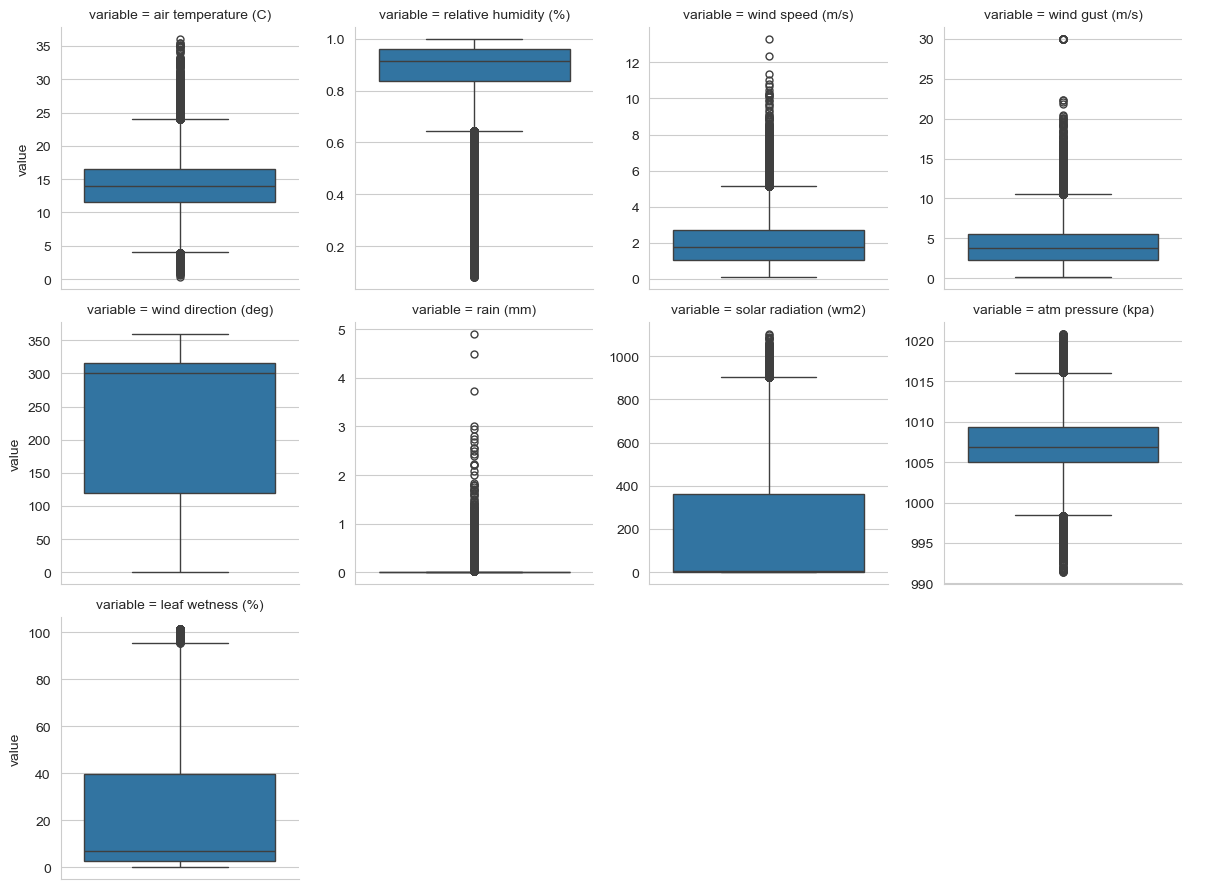

In [39]:
#### Replot distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()

### Check the leaf wetness values over 100
Set these to cap at 100


In [40]:
df.loc[df['leaf wetness (%)'] > 100]

,time (PST),air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (wm2),atm pressure (kpa),leaf wetness (%)
13691,2021-06-16 11:20:00,26.7,0.542,2.07,3.32,327.3,0.0,958.0,1002.3,100.91
13692,2021-06-16 11:30:00,26.9,0.552,2.36,4.33,320.4,0.0,966.0,1002.1,101.17
13693,2021-06-16 11:40:00,26.8,0.558,2.41,4.43,323.4,0.0,971.0,1002.1,101.15
13816,2021-06-17 09:50:00,21.7,0.772,2.31,4.68,304.3,0.0,850.0,1001.7,100.95
13817,2021-06-17 10:00:00,21.7,0.783,2.53,5.53,301.1,0.0,871.0,1001.7,100.93
...,...,...,...,...,...,...,...,...,...,...
21581,2021-08-19 13:50:00,22.8,0.689,2.03,5.33,296.0,0.0,872.0,1004.9,100.93
21582,2021-08-19 14:00:00,22.9,0.686,2.39,4.62,321.7,0.0,872.0,1004.8,101.07
21583,2021-08-19 14:10:00,22.6,0.691,2.54,4.35,311.9,0.0,751.0,1004.6,101.01
21584,2021-08-19 14:20:00,23.2,0.679,2.18,6.15,298.2,0.0,828.0,1004.5,100.47


In [41]:
#### Cap leaf wetness at 100 ####
df['leaf wetness (%)'] =  df['leaf wetness (%)'].apply(lambda x: 100 if x > 100 else x)

### Save out cleaned data

In [42]:
#### Save out cleaned data ####
if summer_subset == True:
    out_fpath = os.path.join(outdir, out_fname_summer)
    df.to_csv(out_fpath)

else:
    out_fpath = os.path.join(outdir, out_fname)
    df.to_csv(out_fpath)

print(out_fpath)

./data/02-clean/sci-christy-airstrip-clean-2021-2023.csv
